# Notes

## Needed Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import optim, nn
import torch.nn.functional as F

from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader, random_split

import os
import tempfile
from PIL import Image

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from ray import tune, train
from ray.train import Checkpoint, session
from ray.tune.schedulers import ASHAScheduler

from functools import partial

## Loading Datasets

Datasets can be imported from `torchvision` or used through a custom dataset class

1. Using `torchvision`
    - Import the `datasets` module from `torchvision`
    - Define a directory (`data_directory`) where the datasets will be stored
    - Import the training dataset (ex:`datasets.MNIST()`) with the following arguments:
        - `root`: The directory where the data will be stored
        - `train=True`: Indicates that we want to import the training dataset
        - `download=True`: Tells PyTorch to download the dataset if it's not already downloaded
        - `transform=None`: By default, the transform is set to `None`, which means no transformations will be applied to the data. You can specify transformations here if needed (e.g., resizing, normalization).
    - We import the testing dataset in a similar way, but with `train=False` to indicate that we want to import the testing dataset.

2. Creating your own custom dataset class
    - Based on the structure of your dataset, you need to create a class with specific functions to load the images 
    - You can then use `random_split` or any similar function to split the dataset into training and testing
    - Find below an example used for HW 3 with directories' names as the labels for the images:
        - Dimsum
        - Cookies
        - Sushi

In [4]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.images = self._load_images()

    def _load_images(self):
        images = []
        for cls in self.classes:
            class_dir = os.path.join(self.root_dir, cls)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                images.append((img_path, self.class_to_idx[cls]))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

## CNN 

The result size of the convolution is determined by the formula:

$$\text{{Result size}} = \frac{{W - F + 2P}}{S} + 1$$

where

- $W$: Input size
- $F$: Filter size
- $P$: Padding
- $S$: Stride

## Helpful Functions

### <span style="color: cyan; font-weight:bold">Training </span>

- <span style="color: pink"><b>F.one_hot </b>(y) </span>

    <u>Notes:</u>
    - Used to one hot encode 
    - Important to use with classification along with softmax/sigmoid 
    - Each label is represented as a distinct vector where a value of 1 is the label

- <span style="color: pink"><b>Dataloader </b>(dataset, batch_size, shuffle) </span>

    <u>Notes:</u>
    - Helps with iterating over a dataset
    - Includes batching (essential for large datasets)
    - Shuffles the data when set to True so the model doesn't learn the exact order of the dataset

- <span style="color: pink"><b>torch.nn.Linear </b>(in_features, out_features, bias = True) </span>

    <u>Notes:</u>
    - Creates a Dense layer with linear transformation (fully connected)
    - in_features is the size of the input sample
    - out_features is the size of the output sample
    - bias indicates whether bias should be included for the neurons in this layers

- <span style="color: pink"><b>torch.nn.MaxPool2d </b>(kernel_size, stride) </span>

    <u>Notes:</u>
    - Performs 2D max pooling over the input 
    - Downsamples the input to reduce its dimensions while maintaining the important points

- <span style="color: pink"><b>nn.ReLU </b>() </span>

    <u>Notes:</u>
    - Applies a rectified linear unit ReLU activation function

- <span style="color: pink"><b>torch.nn.Conv2d </b>(in_channels, out_channels, kernel_size, stride, padding) </span>

    <u>Notes:</u>
    - Creates a convolutional layer
    - in and out channels describe the input and output channels dimensions (3 for RGB input)


### <span style="color: cyan; font-weight:bold">Performance Metrics </span>

- <span style="color: pink"><b>accuracy_score </b>(y_real, y_predicted) </span>
- <span style="color: pink"><b>precision_score </b>(y_real, y_predicted, average='macro') </span>
- <span style="color: pink"><b>recall_score </b>(y_real, y_predicted, average='macro') </span>
- <span style="color: pink"><b>f1_score </b>(y_real, y_predicted, average='macro') </span>

# Code Examples

In [1]:
#!pip install torch torchvision
import torch
from torch import nn
from torch import optim                             # used to compute the derivative
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import numpy as np
from matplotlib import pyplot as plt

from IPython.display import Markdown

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Tensors

- Used to encode $x$, $y$, and weights ($w's$) 
- Can run on GPUs

### Initialization

In [16]:
# you can initialize directly from an array
data = [[1, 2], [3, 4]]
x_data = torch.tensor(data)
x_data

tensor([[1, 2],
        [3, 4]])

In [17]:
# you can use a numpy array as well
array = np.array(data)
x_np = torch.from_numpy(array)
x_np

tensor([[1, 2],
        [3, 4]], dtype=torch.int32)

In [18]:
# you can also initialize using other tensors
# by doing so, the new tensor has the same shape and datatype as the original tensor unless specified otherwise
x_ones = torch.ones_like(x_data)
print(x_ones, '\n')

x_rand = torch.rand_like(x_data, dtype = torch.float)
print(x_rand)

tensor([[1, 1],
        [1, 1]]) 

tensor([[0.6945, 0.8418],
        [0.3488, 0.8325]])


In [19]:
# it's possible to use a random or constant value
shape = (2,3,)
rand_tensor = torch.rand(shape)
rand_tensor[0][0] = 0
rand_tensor

tensor([[0.0000, 0.4071, 0.4852],
        [0.8671, 0.5239, 0.8597]])

In [20]:
# requires_grad should be set to False if you want the autgrad to begin recording operations on a tensor
# default is True
x = torch.tensor([2.0], requires_grad=True)
y = x ** 2 + 3 * x + 1

# Tensor.grad is None by default
# when backward() is called, the gradients for self are computed 
# more calls to backward() will add gradients into it
y.backward()
print(x.grad)   # gradient of y w.r.t x at x = 2

# y'(2) = 2(x) + 3 = 2(2) + 3 = 7 --> gradient
# if you do backward again for this case, it will give an error

tensor([7.])


### Attributes and Operations

In [21]:
tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


In [22]:
# to move your tensor to the GPU:
if torch.cuda.is_available():
  tensor = tensor.to('cuda')

In [23]:
# indexing is similar to that of numpy
tensor = torch.rand(4, 4)
print('Original tensor: ', tensor,'\n')
print('First row: ',tensor[0])
print('First column: ', tensor[:, 0])
print('Last column:', tensor[..., -1])
tensor[:,1] = 0
print('Edited tensor: ',tensor)

Original tensor:  tensor([[0.1270, 0.5514, 0.3889, 0.4026],
        [0.5808, 0.7580, 0.5242, 0.5843],
        [0.6726, 0.4872, 0.3109, 0.2313],
        [0.0439, 0.4753, 0.5367, 0.2424]]) 

First row:  tensor([0.1270, 0.5514, 0.3889, 0.4026])
First column:  tensor([0.1270, 0.5808, 0.6726, 0.0439])
Last column: tensor([0.4026, 0.5843, 0.2313, 0.2424])
Edited tensor:  tensor([[0.1270, 0.0000, 0.3889, 0.4026],
        [0.5808, 0.0000, 0.5242, 0.5843],
        [0.6726, 0.0000, 0.3109, 0.2313],
        [0.0439, 0.0000, 0.5367, 0.2424]])


In [24]:
# you can concatenate tensors
# dim = 1 (hstack aka next to each other) and dim = 0 (vstack aka below the first one)
t1 = torch.cat([tensor, tensor, tensor], dim=1)
t2 = torch.vstack([tensor, tensor, tensor])

print('cat: ', t1, '\n')
print('vstack: ', t2, '\n')

cat:  tensor([[0.1270, 0.0000, 0.3889, 0.4026, 0.1270, 0.0000, 0.3889, 0.4026, 0.1270,
         0.0000, 0.3889, 0.4026],
        [0.5808, 0.0000, 0.5242, 0.5843, 0.5808, 0.0000, 0.5242, 0.5843, 0.5808,
         0.0000, 0.5242, 0.5843],
        [0.6726, 0.0000, 0.3109, 0.2313, 0.6726, 0.0000, 0.3109, 0.2313, 0.6726,
         0.0000, 0.3109, 0.2313],
        [0.0439, 0.0000, 0.5367, 0.2424, 0.0439, 0.0000, 0.5367, 0.2424, 0.0439,
         0.0000, 0.5367, 0.2424]]) 

vstack:  tensor([[0.1270, 0.0000, 0.3889, 0.4026],
        [0.5808, 0.0000, 0.5242, 0.5843],
        [0.6726, 0.0000, 0.3109, 0.2313],
        [0.0439, 0.0000, 0.5367, 0.2424],
        [0.1270, 0.0000, 0.3889, 0.4026],
        [0.5808, 0.0000, 0.5242, 0.5843],
        [0.6726, 0.0000, 0.3109, 0.2313],
        [0.0439, 0.0000, 0.5367, 0.2424],
        [0.1270, 0.0000, 0.3889, 0.4026],
        [0.5808, 0.0000, 0.5242, 0.5843],
        [0.6726, 0.0000, 0.3109, 0.2313],
        [0.0439, 0.0000, 0.5367, 0.2424]]) 



In [25]:
# you can do matrix multiplication as:
# method 1
y1 = tensor @ tensor.T
# method 2
y2 = tensor.matmul(tensor.T)
# method 3
y3 = torch.rand_like(tensor)
torch.matmul(tensor, tensor.T, out=y3)

tensor([[0.3295, 0.5129, 0.2995, 0.3119],
        [0.5129, 0.9536, 0.6888, 0.4485],
        [0.2995, 0.6888, 0.6025, 0.2525],
        [0.3119, 0.4485, 0.2525, 0.3487]])

In [26]:
agg = tensor.sum()  # tensor of 1 number/element
agg_item = agg.item()   # item() converts it to a python numerical value
agg_item

4.645740509033203

In [116]:
# to do in place operations (ex: +=, -=), use '_' suffix
print('Original tensor: ', tensor, '\n')
tensor.add_(5)
print('New tensor: ', tensor, '\n')


Original tensor:  tensor([[0.2360, 0.0000, 0.4758, 0.7177],
        [0.2257, 0.0000, 0.0835, 0.4649],
        [0.5960, 0.0000, 0.8659, 0.7233],
        [0.9533, 0.0000, 0.2602, 0.5987]]) 

New tensor:  tensor([[5.2360, 5.0000, 5.4758, 5.7177],
        [5.2257, 5.0000, 5.0835, 5.4649],
        [5.5960, 5.0000, 5.8659, 5.7233],
        [5.9533, 5.0000, 5.2602, 5.5987]]) 



## Perceptron

### Example 1: Simple Perceptron

Example requirements:
- Have 4 inputs and a single output
- Initialize the weights to 1
- Consider a bias term
- Take training points as $x_1 = 5$, $x_2 = -2$, $y=2$
- Use backpropagation 
- Set 𝛼 = 0.1
- Use squared loss function

In [29]:
x = torch.tensor([[5., -2.]])
y = torch.tensor([[2.]])
w = torch.ones((1,2))

x = x.to(device)
y = y.to(device)

h = nn.Linear(2, 1, bias = True)
h.weight = nn.Parameter(w)
h.bias = nn.Parameter(torch.tensor([[1.]]))
h = h.to(device)

optimizer = optim.SGD(h.parameters(), lr = .1)

cost = nn.MSELoss()

optimizer.zero_grad()
out = h(x)
print(f'Forward Pass, h = {h}')
loss = cost(out, y)
loss.backward()
print(f'Backward pass, Derivatives= {h.bias.grad} {h.weight.grad}')
optimizer.step()
print(f'Weights update, w= {h.bias.detach().cpu().numpy()} {h.weight.detach().cpu().numpy()}')


Forward Pass, h = Linear(in_features=2, out_features=1, bias=True)
Backward pass, Derivatives= tensor([[4.]], device='cuda:0') tensor([[20., -8.]], device='cuda:0')
Weights update, w= [[0.6]] [[-1.   1.8]]


### Example 2: Linear

In [31]:
np.random.seed(22)
x_data = np.sort(-4. + 3. * np.random.rand(30))
y_data = 7. * x_data + np.random.randn(30)

x = torch.tensor(x_data[:,np.newaxis], dtype=torch.float32)
y = torch.tensor(y_data[:,np.newaxis], dtype=torch.float32)

x = x.to(device)
y = y.to(device)

h = nn.Linear(1, 1, bias=True)
h = h.to(device)

optimizer = optim.SGD(h.parameters(), lr = 0.1)
cost = nn.MSELoss()

for i in range(50):
    optimizer.zero_grad()
    out = h(x)
    loss = cost(out, y)
    loss.backward()
    optimizer.step()
    
    print(f'\nEpoch [{i + 1} / {50}]')
    print('=================================')
    print(f'Forward Pass: h = {h} | Backward Pass: Derivatives = {h.bias.grad} {h.weight.grad} | Weights Update: w = {h.bias.detach().cpu().numpy()} {h.weight.detach().cpu().numpy()}')


Epoch [1 / 50]
Forward Pass: h = Linear(in_features=1, out_features=1, bias=True) | Backward Pass: Derivatives = tensor([36.3828], device='cuda:0') tensor([[-98.8124]], device='cuda:0') | Weights Update: w = [-3.2406785] [[9.597263]]

Epoch [2 / 50]
Forward Pass: h = Linear(in_features=1, out_features=1, bias=True) | Backward Pass: Derivatives = tensor([-18.8649], device='cuda:0') tensor([[49.9095]], device='cuda:0') | Weights Update: w = [-1.3541852] [[4.606313]]

Epoch [3 / 50]
Forward Pass: h = Linear(in_features=1, out_features=1, bias=True) | Backward Pass: Derivatives = tensor([9.1380], device='cuda:0') tensor([[-25.4460]], device='cuda:0') | Weights Update: w = [-2.267982] [[7.150913]]

Epoch [4 / 50]
Forward Pass: h = Linear(in_features=1, out_features=1, bias=True) | Backward Pass: Derivatives = tensor([-5.0431], device='cuda:0') tensor([[12.7403]], device='cuda:0') | Weights Update: w = [-1.7636749] [[5.8768787]]

Epoch [5 / 50]
Forward Pass: h = Linear(in_features=1, out_fe

In [32]:
print('h Weight: ', h.weight)
print('h Bias: ', h.bias)

h Weight:  Parameter containing:
tensor([[6.6108]], device='cuda:0', requires_grad=True)
h Bias:  Parameter containing:
tensor([-1.1111], device='cuda:0', requires_grad=True)


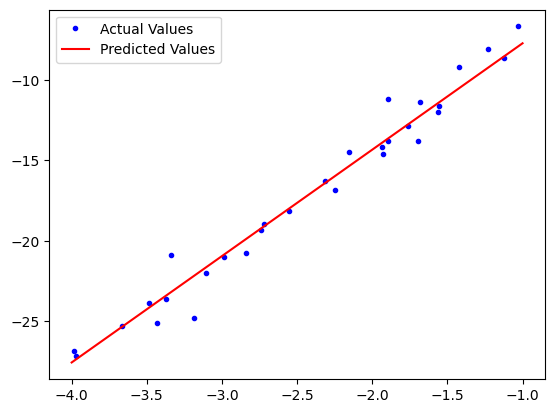

In [37]:
x_new = torch.linspace(-4, -1, 100).view(-1, 1)
x_new = x_new.to(device)
y_new = h(x_new)

plt.plot(x_data, y_data, 'b.', label = 'Actual Values')
plt.plot(x_new.detach().cpu().numpy(), y_new.detach().cpu().numpy(),'r', label = 'Predicted Values')
plt.legend()

### Example 3: Nonlinear

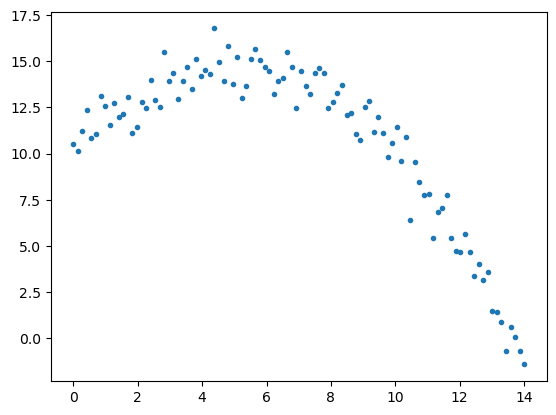

In [39]:
# Generate synthetic data for number of hours spend on video games vs happiness level
np.random.seed(42)
hours = torch.linspace(0, 14, 100).view(-1, 1) # 100 numbers between 0 and 14
happiness = 10 + 2 * hours + 0.2*np.random.normal(0, 5, 100).astype(np.float32).reshape(-1,1) - 0.2 * hours**2
x = hours
y = happiness

plt.plot(x, y, '.')

In [40]:
# TODO
# 2 hidden layers; each will have 6 neurons (for each neuron, we have a bias term), use ReLU for the function g in the hidden layers

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(1, 6, bias=True)
        # self.fc1 = nn.ReLU()
        self.layer2 = nn.Linear(6, 6)
        # self.fc2 = nn.ReLU()
        self.layer3 = nn.Linear(6, 1)

    def forward(self, x):
        # x= self.layer1(x)
        # x= self.fc1(x)
        # x= self.layer2(x)
        # x= self.fc2(x)
        # x= self.layer3(x)
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x

x = x.to(device)
y = y.to(device)  
model = Model()
model = model.to(device)

num_epochs = 10000
optimizer = optim.SGD(model.parameters(), lr = 0.001)
criterion = nn.MSELoss()

for epoch in range(num_epochs):
    y_pred = model(x)
    loss = criterion(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch + 1} / {num_epochs}] -- Loss: {loss.item():.4f}')


Epoch [500 / 10000] -- Loss: 9.7502
Epoch [1000 / 10000] -- Loss: 7.7079
Epoch [1500 / 10000] -- Loss: 3.3365
Epoch [2000 / 10000] -- Loss: 2.9105
Epoch [2500 / 10000] -- Loss: 2.0706
Epoch [3000 / 10000] -- Loss: 1.6880
Epoch [3500 / 10000] -- Loss: 1.5204
Epoch [4000 / 10000] -- Loss: 1.3945
Epoch [4500 / 10000] -- Loss: 1.2864
Epoch [5000 / 10000] -- Loss: 1.1208
Epoch [5500 / 10000] -- Loss: 1.1249
Epoch [6000 / 10000] -- Loss: 1.0670
Epoch [6500 / 10000] -- Loss: 1.0102
Epoch [7000 / 10000] -- Loss: 0.9975
Epoch [7500 / 10000] -- Loss: 0.9296
Epoch [8000 / 10000] -- Loss: 0.8495
Epoch [8500 / 10000] -- Loss: 0.8531
Epoch [9000 / 10000] -- Loss: 0.8464
Epoch [9500 / 10000] -- Loss: 0.8311
Epoch [10000 / 10000] -- Loss: 0.8346


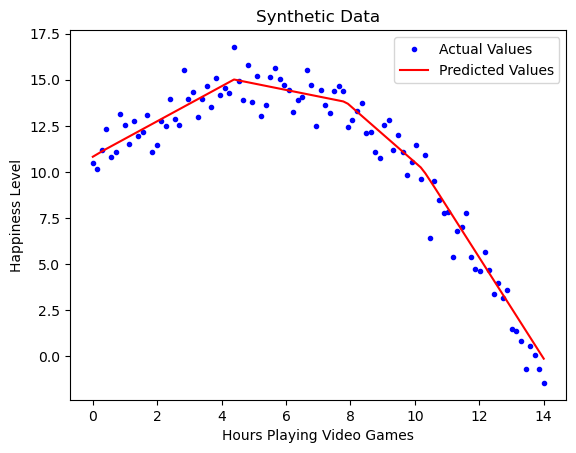

In [43]:
plt.plot(x.detach().cpu().numpy(), y.detach().cpu().numpy(), 'b.', label = 'Actual Values')

out = model.forward(x)
plt.plot(x.detach().cpu().numpy(), out.detach().cpu().numpy(), 'r', label = 'Predicted Values')
plt.xlabel('Hours Playing Video Games')
plt.ylabel('Happiness Level')
plt.title('Synthetic Data')
plt.legend()

### Example 4: MNIST

In [44]:
training_data = datasets.MNIST(
    root='~/Downloads/VisionCNN',
    train=True,
    download=True,
    transform=transforms.Compose([
              transforms.ToTensor()])
)                                     # download MNIST dataset, save it in the Downloads folder, we only want to get the training part
                                      # download = True --> download if it doesn't exist
                                      # transforms.ToTensor() --> convert each image in the PIL data type to Tensor
                                      # if you want to apply Gaussian Blur, flip the image, do some data augmentation --> all can be specified here 

# training_data[0] --> first image in the training dataset, prints as a tuple -- PIL image & its ground truth label which is 8 (for e.g.)
# training_data[0][0] --> display the actual image
# Above is assumed without the transforms.ToTensor() part

test_data = datasets.MNIST(
    root='~/Downloads/VisionCNN',
    train=False,
    download=True,
    transform=ToTensor()
)
batchsize = 64
train_dataloader = DataLoader(training_data, batch_size=batchsize, shuffle=True)        # accepts a dataset, specify the batch size, do you want to shuffle, etc.
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=True)

In [46]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.layer1 = nn.Linear(28*28, 10, bias=True)
        self.prob = nn.LogSoftmax(dim = 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.prob(x)
        return x
    
model = Classifier()
model = model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001)

J_history = []
num_epochs= 5
for epoch in range(num_epochs):
    tot_loss = 0

    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.reshape(inputs.shape[0], -1)
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        pred = model(inputs)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        tot_loss += loss.item()

        if i % 300 == 0:
            print(f'Epoch [{epoch + 1} / {num_epochs}] -- {i + 1} | Loss: {loss.item():.4f}')
    
    J_history += [tot_loss]

Epoch [1 / 5] -- 1 | Loss: 2.2976
Epoch [1 / 5] -- 301 | Loss: 2.0077
Epoch [1 / 5] -- 601 | Loss: 1.8362
Epoch [1 / 5] -- 901 | Loss: 1.5851
Epoch [2 / 5] -- 1 | Loss: 1.5436
Epoch [2 / 5] -- 301 | Loss: 1.3975
Epoch [2 / 5] -- 601 | Loss: 1.3603
Epoch [2 / 5] -- 901 | Loss: 1.1651
Epoch [3 / 5] -- 1 | Loss: 1.1500
Epoch [3 / 5] -- 301 | Loss: 1.1807
Epoch [3 / 5] -- 601 | Loss: 1.1601
Epoch [3 / 5] -- 901 | Loss: 1.0023
Epoch [4 / 5] -- 1 | Loss: 1.0391
Epoch [4 / 5] -- 301 | Loss: 0.9443
Epoch [4 / 5] -- 601 | Loss: 1.0341
Epoch [4 / 5] -- 901 | Loss: 0.9168
Epoch [5 / 5] -- 1 | Loss: 0.9556
Epoch [5 / 5] -- 301 | Loss: 0.8216
Epoch [5 / 5] -- 601 | Loss: 0.7933
Epoch [5 / 5] -- 901 | Loss: 0.8483


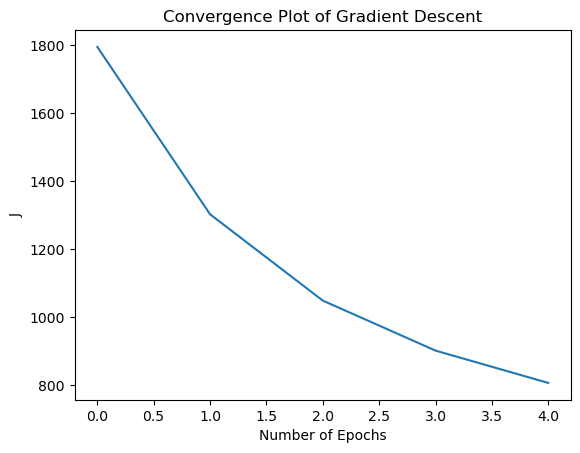

In [47]:
plt.plot(J_history)
plt.title('Convergence Plot of Gradient Descent')
plt.xlabel('Number of Epochs')
plt.ylabel('J')
plt.show()

In [49]:
x_test = []
y_test = []
for i in range(20):
    x_test.append(np.array(test_data[i][0]))
    y_test.append(test_data[i][1])

x_test_new = np.array(x_test).reshape(-1, 28*28)
y_test = np.array(y_test)
x_tensor = torch.Tensor(x_test_new)
x_tensor = x_tensor.to(device)
y_pred = model(x_tensor).argmax(axis=1)


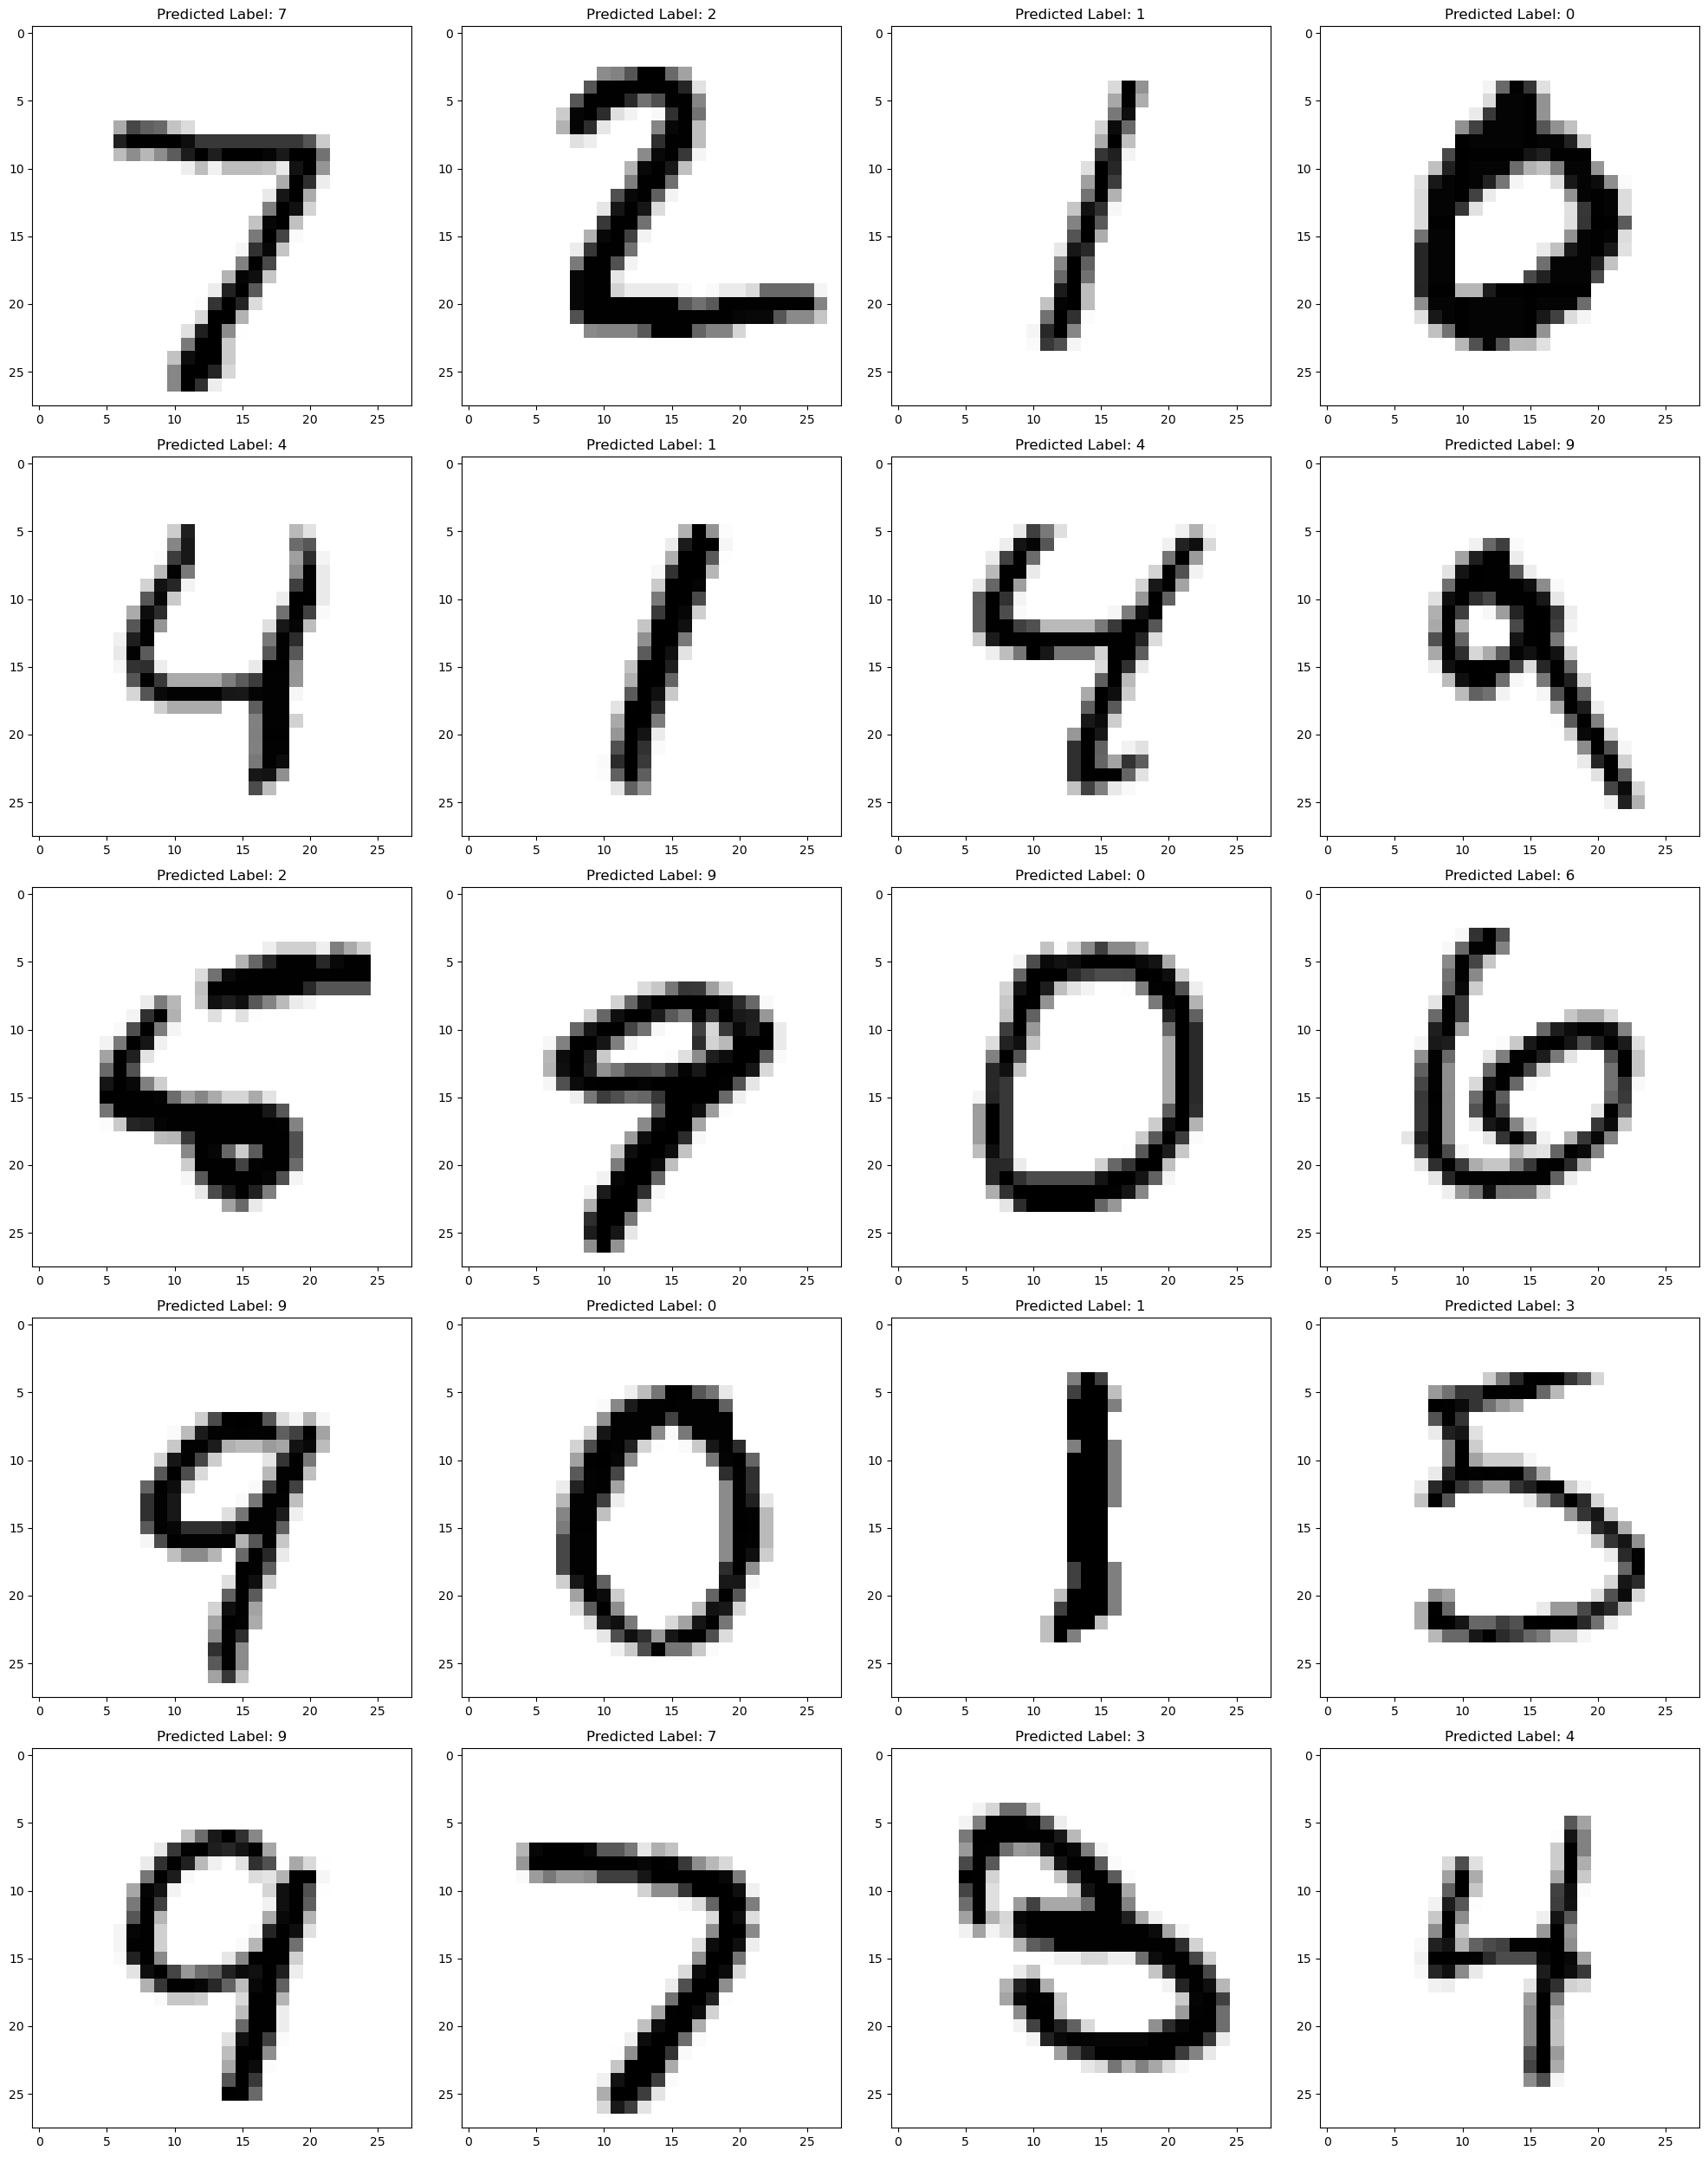

In [50]:
fig, axes = plt.subplots(5, 4, figsize=(20, 25))

for i in range(20):
    plt.subplot(5, 4, i + 1)
    
    plt.imshow(x_test[i].squeeze(), cmap='gray_r')
    
    plt.title(f"Predicted Label: {y_pred[i]}")

fig.tight_layout()

plt.show()

## Convolutional Neural Network

In [51]:
torch.manual_seed(0)

transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
trainset = datasets.CIFAR10(
    root='~/Downloads/VisionCNN',
    train=True,
    download=True,
    transform=transform
)

testset = datasets.CIFAR10(
    root='~/Downloads/VisionCNN',
    train=False,
    download=True,
    transform=transform
)

batchsize = 64
train_dataloader = DataLoader(trainset, batch_size=batchsize, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=batchsize, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


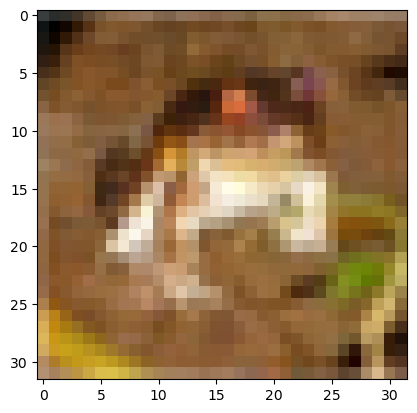

In [52]:
transform_back = transforms.Compose([transforms.Normalize((-1.,-1.,-1.),(2.,2.,2.)), transforms.ToPILImage()])

plt.imshow(transform_back(trainset[0][0]))

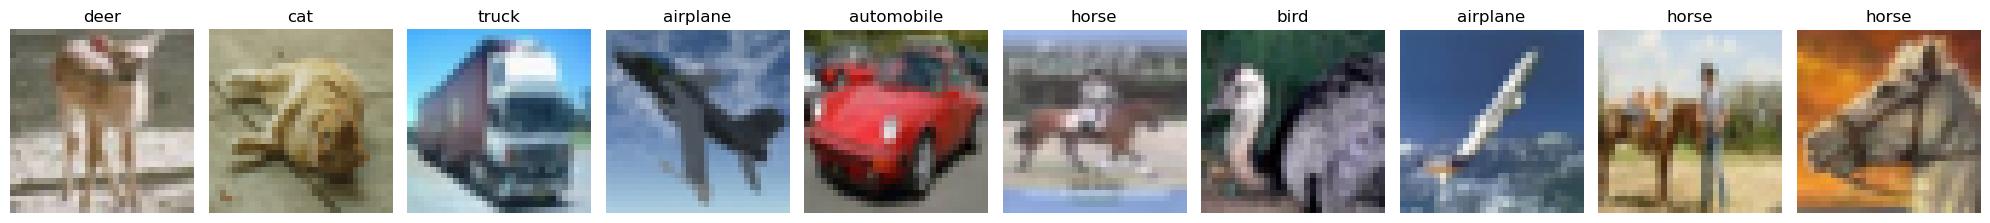

In [53]:
images, labels = next(iter(train_dataloader))                                   # get one batch of training data

idx_to_class = {value: key for key, value in trainset.class_to_idx.items()}

plt.figure(figsize = (20, 30))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(transform_back(images[i]))
    plt.axis('off')
    plt.title(idx_to_class[labels[i].item()])

plt.tight_layout()
plt.show()

*   ksize = 3 x 3 , padding = 1 , stride = 1
*   max pooling , ksize = 2 , stride = 2

*   Neural Network
    * 32 Conv Filter -- Relu -- 64 Conv Filter -- Relu -- Max Pool
    * 256 Conv Filter -- Relu -- 256 Conv Filter -- Relu -- Max Pool
    * 128 Conv Filter -- Relu -- 128 Conv Filter -- Relu -- Max Pool
    * 1024 -- Relu -- 512 -- Relu -- 10

In [54]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel,self).__init__()

        self.network = nn.Sequential(

            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # 32 x 32 x 32
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # 64 x 32 x 32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 2), # 64 x 16 x 16

            nn.Conv2d(in_channels=64, out_channels=256,  kernel_size=3, stride=1, padding=1), # 256 x 16 x 16
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256,  kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 256 x 8 x 8

            nn.Conv2d(in_channels=256, out_channels=128,  kernel_size=3, stride=1, padding=1), # 128 x 8 x 8
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128,  kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), #128 x 4 x 4

            nn.Flatten(),

            nn.Linear(128*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        return self.network(x)

In [55]:
model = CNNModel()
print(model)

CNNModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=2048, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=10

In [58]:
optimizer=optim.Adam(model.parameters(), lr=0.001)
criterion=nn.CrossEntropyLoss()
train_history = []
val_history = []

model.train()
model = model.to(device)

for epoch in range(5):
    train_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dataloader,0):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss+= loss.item()

    with torch.no_grad():
        val_loss = 0.0
        for (inputs, labels) in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            output = model(inputs)
            loss = criterion(output, labels)
            val_loss+=loss.item()

    print(f'Epoch [{epoch + 1}] --> Training Loss: {train_loss / len(trainset)} | Validation Loss: {val_loss / len(testset)}')
    train_history += [train_loss / len(trainset)]
    val_history += [val_loss / len(testset)]

Epoch [1] --> Training Loss: 0.011891134126186372 | Validation Loss: 0.01211365736424923


In [ ]:
plt.plot(train_history, 'b', label = 'Train Loss')
plt.plot(val_history, 'r', label = 'Validation Loss')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('J')
plt.title('Model Gradient Descent Convergence Plot')
plt.show()

In [ ]:
images, labels = next(iter(test_dataloader))              # takes one batch of testing data

outputs = model(images)
_, predicted = torch.max(outputs, dim = 1)                # gives us the index of the max value along the specified dimension

plt.figure(figsize=(20,30))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.tight_layout()
    plt.imshow(transform_back(images[i]))
    plt.axis('off')
    plt.title(idx_to_class[predicted[i].item()])
    print(f'Actual: {idx_to_class[labels[i].item()]} \t\t Predicted: {idx_to_class[predicted[i].item()]}')
plt.show()

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the Network (Model 2) on the 10000 Test Images: {100 * correct / total}%')